In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [26]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [27]:
import pandas_datareader
import datetime

In [28]:
pre_days =1
mem_his_days = 10
epoch = 500

In [29]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2021, 9, 1)

df = pandas_datareader.data.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)

# normalize = lambda x: (x - x.min()) / (x.max() - x.min())

df['PreHigh'] = df['High'].shift(1)
df["Change"] = df['High'] / df['PreHigh']
print(df.head())

def parse_values(x):
    if x < 0.95:
       return 0
    elif x < 1.0:
       return 1
    elif x < 1.05:
       return 2
    return 3

df['Change'] = df['Change'].apply(parse_values)
print(df.head())
df = df.drop('High', axis=1)
df = df.drop('PreHigh', axis=1)
# df = df.drop('Low', axis=1)
# df = df.drop('Open', axis=1)
# df = df.drop('Close', axis=1)
df = df.dropna()
print(df.head())

scaler = MinMaxScaler((0, 4))

sca = scaler.fit_transform(df.iloc[:, :-1])
label = np.array(df.iloc[:, -1])
print(sca)
print(label)

               Open    High      Low    Close       Volume  PreHigh    Change
Date                                                                         
2004-08-19  2.50000  2.6015  2.39900  2.50850  894076000.0      NaN       NaN
2004-08-20  2.52525  2.7270  2.51250  2.70775  457144000.0   2.6015  1.048241
2004-08-23  2.76875  2.8370  2.72625  2.73500  365488000.0   2.7270  1.040337
2004-08-24  2.78100  2.7900  2.58925  2.62175  305252000.0   2.8370  0.983433
2004-08-25  2.62400  2.7000  2.59700  2.65000  183956000.0   2.7900  0.967742
               Open    High      Low    Close       Volume  PreHigh  Change
Date                                                                       
2004-08-19  2.50000  2.6015  2.39900  2.50850  894076000.0      NaN       3
2004-08-20  2.52525  2.7270  2.51250  2.70775  457144000.0   2.6015       2
2004-08-23  2.76875  2.8370  2.72625  2.73500  365488000.0   2.7270       2
2004-08-24  2.78100  2.7900  2.58925  2.62175  305252000.0   2.8370       

In [30]:
deq = collections.deque()

x = []
for row in sca:
    deq.append(list(row))
    if len(deq) > mem_his_days:
        deq.popleft()
    if len(deq) == mem_his_days:
        x.append(list(deq))
x = x[:-pre_days]
y = label[mem_his_days-1:-pre_days]
x, y = np.array(x).reshape(-1,10,4,1), np.array(y)
print(x.shape)
print(y.shape)

(4279, 10, 4, 1)
(4279,)


In [31]:
total_num = len(x)
train_num = int(total_num * 0.98)
print(train_num)

4193


In [32]:
x_train, y_train = x[:train_num], y[:train_num]
x_test, y_test = x[train_num:], y[train_num:]

batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(train_num).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.shuffle(total_num - train_num).batch(batch_size=batch_size).prefetch(tf.data.experimental.AUTOTUNE)

sample = next(iter(train_ds))
print('x_train.shape:', sample[0].shape)
print('y_train.shape:', sample[1].shape)

x_train.shape: (128, 10, 4, 1)
y_train.shape: (128,)


In [33]:
input_shape = sample[0].shape[-3:]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,4,input_shape=input_shape,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64,4,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128,4,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dense(4,activation='softmax'))
model.build(input_shape=[None,10,4])

model.summary()

# inputs = tf.keras.Input(shape=input_shape)

# x = tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
# x = tf.keras.layers.Dropout(0.2)(x)

# x = tf.keras.layers.GRU(50, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.Dropout(0.2)(x)

# x = tf.keras.layers.GRU(50, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.Dropout(0.2)(x)

# x = tf.keras.layers.GRU(50, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.Dropout(0.2)(x)

# x = tf.keras.layers.GRU(50, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.Dropout(0.2)(x)

# x = tf.keras.layers.LSTM(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.Dropout(0.2)(x)

# outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

# model = tf.keras.Model(inputs, outputs)

# model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 10, 4, 32)         544       
                                                                 
 batch_normalization_8 (Bat  (None, 10, 4, 32)         128       
 chNormalization)                                                
                                                                 
 re_lu_8 (ReLU)              (None, 10, 4, 32)         0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 2, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 2, 64)          32832     
                                                                 
 batch_normalization_9 (Bat  (None, 5, 2, 64)         

In [34]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metrics])

# model.compile(optimizer=tf.keras.optimizers.RMSprop(),
#               loss=tf.keras.losses.MeanAbsoluteError(),
#               metrics=tf.keras.losses.MeanSquaredLogarithmicError())

def lr_schedule(epoch):
    if epoch > 350:
        return 0.00001
    if epoch > 200:
        return 0.00005
    if epoch > 150:
        return 0.0001
    if epoch > 100:
        return 0.0002
    if epoch > 50:
        return 0.0005
    return 0.001
        
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule,verbose=True)

history = model.fit(train_ds,
                    epochs=epoch,
                    validation_data=test_ds,
                    callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
33/33 [==============================] - 2s 33ms/step - loss: 1.0957 - sparse_categorical_accuracy: 0.4431 - val_loss: 1.2104 - val_sparse_categorical_accuracy: 0.6628 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/500
33/33 [==============================] - 1s 35ms/step - loss: 0.8217 - sparse_categorical_accuracy: 0.5173 - val_loss: 1.0751 - val_sparse_categorical_accuracy: 0.3372 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/500
33/33 [==============================] - 1s 30ms/step - loss: 0.7737 - sparse_categorical_accuracy: 0.5450 - val_loss: 1.0047 - val_sparse_categorical_accuracy: 0.3372 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/500
33/33 [==============================] - 1s 29ms/step - loss: 0.7520 - sparse_categorical_accuracy: 0.5683 - val_loss: 1.1496 - val_sparse_categorical_ac

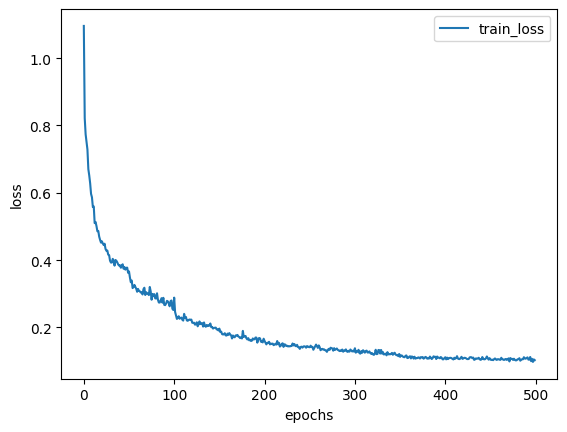

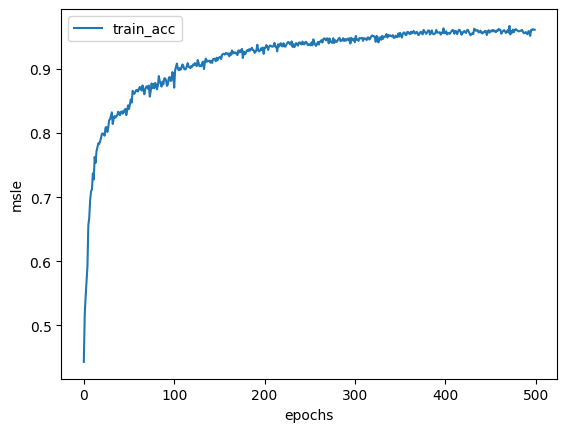

In [35]:
train_acc = history.history['sparse_categorical_accuracy']
train_loss = history.history['loss']

plt.figure()
plt.plot(range(epoch), train_loss, label='train_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(range(epoch), train_acc, label='train_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('msle')
plt.show()

3/3 [==============================] - 0s 7ms/step
[1 1 1 2 2 2 1 1 1 2 2 1 1 1 2 2 2 1 2 1 1 2 2 1 2 2 1 1 2 1 2 2 1 2 2 2 2
 2 2 1 2 1 1 2 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 1 1 2 1 1 1 2 2 2 1 1 2 1 1 2
 2 1 1 1 2 2 2 1 1 2 2 2]


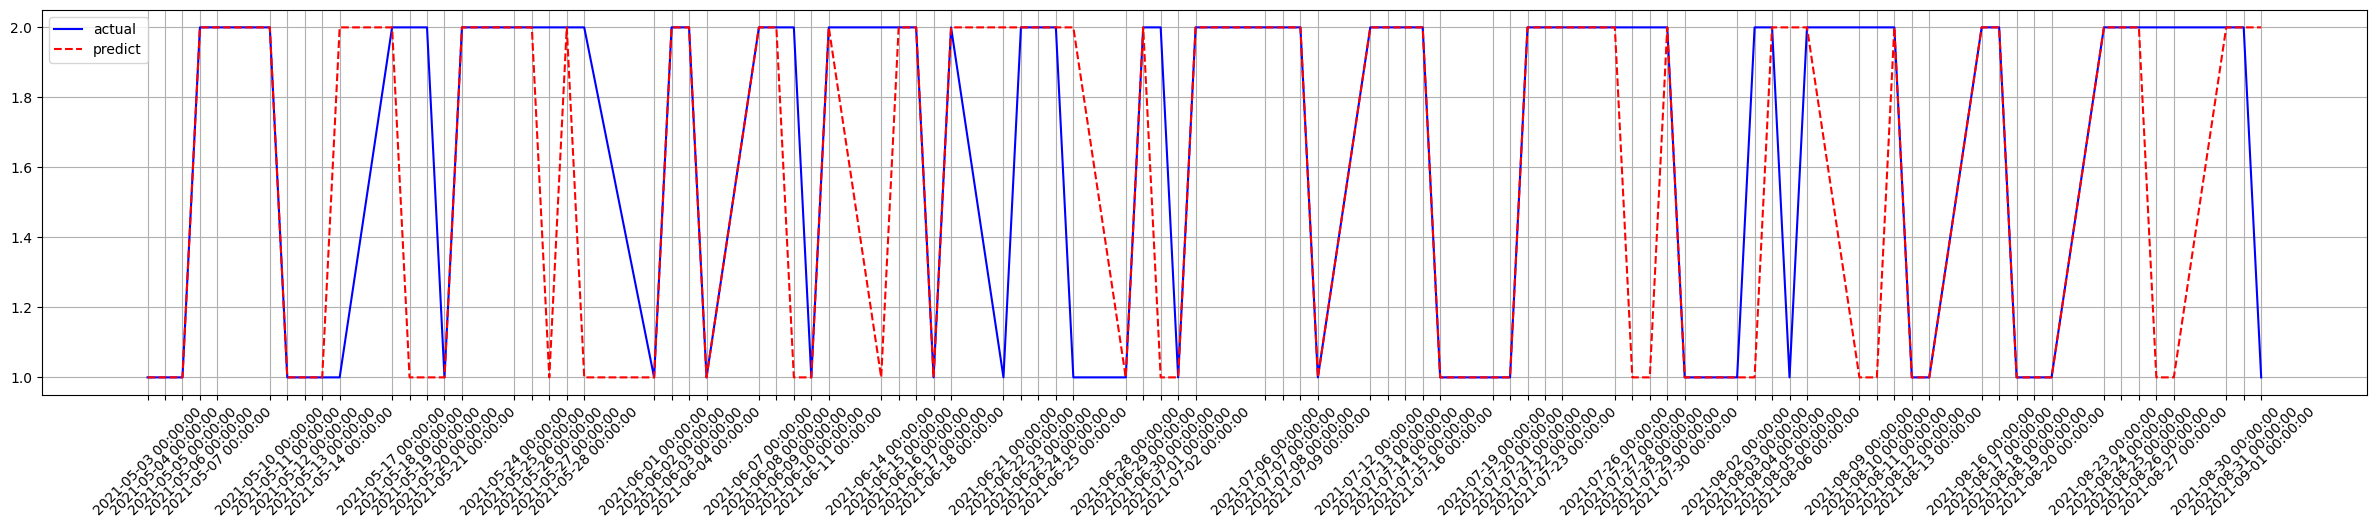

In [36]:
model.evaluate(test_ds)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

df_time = df.index[-len(y_test):]

fig = plt.figure(figsize=(30, 5))
axes = fig.add_subplot(111)
axes.plot(df_time, y_test, 'b-', label='actual')
axes.plot(df_time, y_pred, 'r--', label='predict')
print(y_pred)
axes.set_xticks(df_time[::1])
axes.set_xticklabels(df_time[::1],rotation=45)

plt.legend()
plt.grid()
plt.show()